In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.signal import butter,filtfilt,find_peaks,find_peaks_cwt,medfilt,savgol_filter,find_peaks
from utils import butter_lowpass_filter, butter_highpass_filter, smooth, positions2onehot, normalize
import torch
import torch.nn as nn
import pandas as pd
from test_metric_utils import *
from models import Unet, Resv2Unet,ULSTM
# from model_AAE import FCAE
from tqdm import tqdm_notebook
import os
import time
import IPython.display as ipd
import multiprocessing
from findpeaks.tests.libs import detect_peaks
import apex
%matplotlib inline

In [2]:
# def inference(model,Speech,n_frame = 192,window_step = 32):
#     assert n_frame%window_step ==0
    
#     model.eval()
#     Speech = np.expand_dims(Speech,axis=-1)
#     EGG_pred = np.zeros_like(Speech)
#     ratio = np.zeros_like(Speech)
#     frame = 0
    
#     while frame*window_step + n_frame <= len(Speech):
#         tmp = Speech[frame*window_step:frame*window_step+n_frame]
#         tmp = torch.Tensor([normalize(tmp)]).cuda() ## preprocessing
        
#         result = model(tmp).cpu().detach().numpy()[0]
#         EGG_pred[frame*window_step:frame*window_step+n_frame] += result ## postprocessing
#         ratio[frame*window_step:frame*window_step+n_frame] +=1
#         frame +=1
    
#     for i in range(len(EGG_pred)):
#         if ratio[i]!=0:
#             EGG_pred[i] = EGG_pred[i]/ratio[i]
#     return EGG_pred[:n_frame + frame*window_step]

def inference(model,Speech,n_frame = 192,window_step = 32,batch_size = 100):
    assert n_frame%window_step ==0
    
    model.eval()
    Speech = np.expand_dims(Speech,axis=-1)
    EGG_pred = np.zeros_like(Speech)
    ratio = np.zeros_like(Speech)
    frame = 0
    tmp = []
    while frame*window_step + n_frame <= len(Speech):
        tmp.append(normalize(Speech[frame*window_step:frame*window_step+n_frame]))
        frame +=1
    
    result = None
    batch_idx = 0
    with torch.no_grad():
        while((batch_idx+1)*batch_size<=len(tmp)):
            _tmp = torch.Tensor(tmp[batch_idx*batch_size:(batch_idx+1)*batch_size]).cuda()
            _result = model(_tmp).cpu().detach().numpy()
            result = _result if result is None else np.concatenate((result,_result))
            batch_idx+=1
        if batch_idx*batch_size != len(tmp):
            _tmp = torch.Tensor(tmp[batch_idx*batch_size:len(tmp)]).cuda()
            _result = model(_tmp).cpu().detach().numpy()
            result = _result if result is None else np.concatenate((result,_result))
        
    for frame in range(len(result)):
        EGG_pred[frame*window_step:frame*window_step+n_frame] += result[frame] ## postprocessing
        ratio[frame*window_step:frame*window_step+n_frame] +=1
#     frame +=1
    
    for i in range(len(EGG_pred)):
        if ratio[i]!=0:
            EGG_pred[i] = EGG_pred[i]/ratio[i]
            
    return EGG_pred[:n_frame + frame*window_step]

In [3]:
# unet_degg = Unet(4,10)
# unet_degg = nn.DataParallel(unet_degg)
# unet_degg.load_state_dict(torch.load("./models/Unet/best-cosloss-dloss.pth"))
# unet_degg.cuda()

# unet = Unet(4,10)
# unet = nn.DataParallel(unet)
# unet.load_state_dict(torch.load("./models/Unet/best-cosloss-Ranger.pth"))
# unet.cuda()

# res_unet = Resv2Unet(nlayers = 4, nefilters = 10,filter_size = 15,merge_filter_size = 5,mode='v1')
# res_unet = nn.DataParallel(res_unet)
# res_unet.load_state_dict(torch.load("./models/Resv2Unet/best-cosloss-Ranger.pth"))
# res_unet.cuda()

# res_unet_2 = Resv2Unet(nlayers = 4, nefilters = 15,filter_size = 15,merge_filter_size = 5)
# res_unet_2 = nn.DataParallel(res_unet_2)
# res_unet_2.load_state_dict(torch.load("./models/Resv2Unet/best-cosloss-Ranger-2.pth"))
# res_unet_2.cuda()
# device = torch.device("cuda:1")
# res_plus = Resv2Unet(nlayers=5,nefilters=64,filter_size=15,merge_filter_size=5)
# res_plus = nn.DataParallel(res_plus)
# res_plus.load_state_dict(torch.load("./models/Resv2Unet_heavy_continue/best-cosloss-Ranger.pth"))
# res_plus.cuda()

# res_long = Resv2Unet(nlayers=5,nefilters=32,filter_size=15,merge_filter_size=5)
# res_long = nn.DataParallel(res_long)
# res_long.load_state_dict(torch.load("./models/Resv2Unet_long_frame_continue/best-cosloss-Ranger.pth"))
# res_long.cuda()

# res_mid = Resv2Unet(nlayers=5,nefilters=48,filter_size=15,merge_filter_size=5)
# res_mid = nn.DataParallel(res_mid)
# res_mid.load_state_dict(torch.load("./models/Resv2Unet_mid_frame/best-cosloss-Ranger.pth"))
# res_mid.cuda()

# res_plus = Resv2Unet(nlayers=5,nefilters=64,filter_size=15,merge_filter_size=5)
# # res_plus = apex.parallel.convert_syncbn_model(res_plus)
# res_plus = nn.DataParallel(res_plus)
# res_plus.load_state_dict(torch.load("./models/exp19_continue/best.pth"))
# res_plus.cuda()

res_rnn = ULSTM(nlayers=5,nefilters=64,filter_size=15,merge_filter_size=5,hidden_size=128,num_layers=1)
# res_plus = apex.parallel.convert_syncbn_model(res_plus)
res_rnn = nn.DataParallel(res_rnn)
res_rnn.load_state_dict(torch.load("./models/exp20/best.pth"))
res_rnn.cuda()

DataParallel(
  (module): ULSTM(
    (UBlock): Resv2Unet(
      (encoder): ModuleList(
        (0): SEBasicBlock(
          (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1): Conv1d(64, 64, kernel_size=(15,), stride=(1,), padding=(7,), bias=False)
          (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv1d(64, 64, kernel_size=(15,), stride=(1,), padding=(7,), bias=False)
          (se): SELayer(
            (avg_pool): AdaptiveAvgPool1d(output_size=1)
            (fc): Sequential(
              (0): Linear(in_features=64, out_features=16, bias=True)
              (1): ReLU(inplace)
              (2): Linear(in_features=16, out_features=64, bias=True)
              (3): Sigmoid()
            )
          )
          (sample): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
        )
        (1): SEBasicBlock(
          (bn1): BatchNorm1d(64, eps=1e-05, momentum=

# TEST CMU Data
## Normal person data

In [4]:
def get_points(EGG,DEGG):
#     EGG = normalize(EGG)
    
    CQ,avg_hl_ratio,avg_pitch = 0,0,0

#     peak_range = (7,15)
#     DEGG = np.gradient(EGG,edge_order = 2)
#     DEGG = medfilt(DEGG, 3)
    DEGG_low,EGG_low = DEGG.copy(),EGG.copy()
    
    DEGG_low[DEGG_low>0] =0
    EGG_low[EGG_low>0] =0
    
#     DEGG_low = find_peaks_cwt(-DEGG_low,np.arange(*peak_range))
    DEGG_low = detect_peaks.detect_peaks(-DEGG_low,mph=0.01, mpd=45)
#     DEGG_low = find_peaks(-DEGG_low,distance=40)
#     EGG_low = find_peaks_cwt(-EGG_low,np.arange(*peak_range))
    EGG_low = detect_peaks.detect_peaks(-EGG_low,mph=0.01, mpd=45)
#     EGG_low = find_peaks(-EGG_low,distance=40)
    
#     print(DEGG_low)
    DEGG_high = []
    for i in range(len(DEGG_low)-1):
        DEGG_high.append(DEGG_low[i] + np.argmax(DEGG[DEGG_low[i]:DEGG_low[i+1]]))

    EGG_high = []
    for i in range(len(EGG_low)-1):
        EGG_high.append(EGG_low[i] + np.argmax(EGG[EGG_low[i]:EGG_low[i+1]]))
    
    DEGG_high, EGG_high = np.array(DEGG_high),np.array(EGG_high)
    for i in range(len(DEGG_high)-1):
        CQ+=(DEGG_low[i+1]-DEGG_high[i])/((DEGG_high[i+1]-DEGG_high[i])*(len(DEGG_high)-1))
    for i in range(len(DEGG_low)-1):
        avg_hl_ratio+=(DEGG[DEGG_high[i]]/(np.abs(DEGG[DEGG_low[i]])+1e-3))/(len(DEGG_low)-1)
        avg_pitch += (16000/(DEGG_low[i+1]-DEGG_low[i]))/(len(DEGG_low)-1) ##avg period
    return DEGG_high/16000,DEGG_low/16000,EGG_high/16000,EGG_low/16000,CQ,avg_hl_ratio,avg_pitch

In [8]:
directory = './datasets/TestData/CMU/'
filelist = os.listdir(directory)
n_frame = 256
window_step = 64

DEGG_high_metrics_final = {'IDR':0, 'MR' : 0, 'FAR':0 ,'IDA':0,'ncycles':0,'nhits':0,'nmisses':0,'nfars':0}
DEGG_low_metrics_final = {'IDR':0, 'MR' : 0, 'FAR':0 ,'IDA':0,'ncycles':0,'nhits':0,'nmisses':0,'nfars':0}
EGG_high_metrics_final = {'IDR':0, 'MR' : 0, 'FAR':0 ,'IDA':0,'ncycles':0,'nhits':0,'nmisses':0,'nfars':0}
EGG_low_metrics_final = {'IDR':0, 'MR' : 0, 'FAR':0 ,'IDA':0,'ncycles':0,'nhits':0,'nmisses':0,'nfars':0}

CQ = []
hl = []
pitch = []
# filelist = filelist[100:110]
for file in tqdm_notebook(filelist[:]):
#     print(file)
    [Speech,EGG_true],sr = librosa.load(directory + file,sr=16000,mono=False)
    Speech = butter_lowpass_filter(Speech,2500,16000)
    itvs = librosa.effects.split(Speech,frame_length = int(256*0.75), hop_length = int(256*0.25),top_db = 15)
    
    EGG_pred = inference(res_rnn,Speech,n_frame = n_frame,window_step = window_step,batch_size=15000)
    EGG_pred = np.squeeze(EGG_pred,axis=-1)
    EGG_pred = smooth(EGG_pred, 25)
    DEGG_pred = np.gradient(EGG_pred,edge_order = 2)
    DEGG_true = np.gradient(EGG_true,edge_order = 2)
    S = []
    E = []
    Ep = []
    D = []
    Dp = []
    for st,ed in itvs:
        if(ed-st >=n_frame*1.5):
            S += list(Speech[st:ed])
            E += list(EGG_true[st:ed])
            Ep += list(EGG_pred[st:ed])
            D += list(DEGG_true[st:ed])
            Dp += list(DEGG_pred[st:ed])
    Speech = np.array(S)
    EGG_true = np.array(E)
    EGG_pred = np.array(Ep)
    DEGG_true = np.array(D)
    DEGG_pred = np.array(Dp)
    
    l = min(len(EGG_pred),len(EGG_true))
    EGG_true =EGG_true[:l]
    EGG_pred =EGG_pred[:l]
    
    EGG_true,EGG_pred = detect_voiced_region(EGG_true,EGG_pred)
    
    DEGG_high_true,DEGG_low_true, EGG_high_true, EGG_low_true,CQ_true,hl_true,pitch_true = get_points(EGG_true,DEGG_true)
    DEGG_high_pred,DEGG_low_pred, EGG_high_pred, EGG_low_pred,CQ_pred,hl_pred,pitch_pred = get_points(EGG_pred,DEGG_pred)
    
    CQ.append([CQ_true,CQ_pred])
    hl.append([hl_true,hl_pred])
    pitch.append([pitch_true,pitch_pred])
    
    DEGG_high_metrics = corrected_naylor_metrics(DEGG_high_true, DEGG_high_pred) ##GOI
    DEGG_low_metrics = corrected_naylor_metrics(DEGG_low_true, DEGG_low_pred) ##GCI
    EGG_high_metrics = corrected_naylor_metrics(EGG_high_true, EGG_high_pred)
    EGG_low_metrics = corrected_naylor_metrics(EGG_low_true, EGG_low_pred)

    DEGG_high_metrics_final['ncycles'] +=DEGG_high_metrics['ncycles']
    DEGG_high_metrics_final['nhits'] +=DEGG_high_metrics['nhits']
    DEGG_high_metrics_final['nmisses'] +=DEGG_high_metrics['nmisses']
    DEGG_high_metrics_final['nfars'] +=DEGG_high_metrics['nfars']
    DEGG_high_metrics_final['IDA'] += DEGG_high_metrics["identification_accuracy"]/len(filelist)

    DEGG_low_metrics_final['ncycles'] +=DEGG_low_metrics['ncycles']
    DEGG_low_metrics_final['nhits'] +=DEGG_low_metrics['nhits']
    DEGG_low_metrics_final['nmisses'] +=DEGG_low_metrics['nmisses']
    DEGG_low_metrics_final['nfars'] +=DEGG_low_metrics['nfars']
    DEGG_low_metrics_final['IDA'] += DEGG_low_metrics["identification_accuracy"]/len(filelist)

    EGG_high_metrics_final['ncycles'] +=EGG_high_metrics['ncycles']
    EGG_high_metrics_final['nhits'] +=EGG_high_metrics['nhits']
    EGG_high_metrics_final['nmisses'] +=EGG_high_metrics['nmisses']
    EGG_high_metrics_final['nfars'] +=EGG_high_metrics['nfars']
    EGG_high_metrics_final['IDA'] += EGG_high_metrics["identification_accuracy"]/len(filelist)

    EGG_low_metrics_final['ncycles'] +=EGG_low_metrics['ncycles']
    EGG_low_metrics_final['nhits'] +=EGG_low_metrics['nhits']
    EGG_low_metrics_final['nmisses'] +=EGG_low_metrics['nmisses']
    EGG_low_metrics_final['nfars'] +=EGG_low_metrics['nfars']
    EGG_low_metrics_final['IDA'] += EGG_low_metrics["identification_accuracy"]/len(filelist)

for d in [DEGG_high_metrics_final,DEGG_low_metrics_final,EGG_high_metrics_final,EGG_low_metrics_final]:
    d['IDR'] = d['nhits']/d['ncycles']
    d['MR'] = d['nmisses']/d['ncycles']
    d['FAR'] = d['nfars']/d['ncycles']

print("=========DEGG_high(GOI) detection========")
print("IDR : %.2f MR : %.2f FAR : %.2f IDA : %.2f ms"
      %(DEGG_high_metrics_final['IDR']*100,DEGG_high_metrics_final['MR']*100,DEGG_high_metrics_final['FAR']*100,DEGG_high_metrics_final['IDA']*1000))

print("=========DEGG_low(GCI) detection========")
print("IDR : %.2f MR : %.2f FAR : %.2f IDA : %.2f ms"
      %(DEGG_low_metrics_final['IDR']*100,DEGG_low_metrics_final['MR']*100,DEGG_low_metrics_final['FAR']*100,DEGG_low_metrics_final['IDA']*1000))

print("=========EGG_high detection========")
print("IDR : %.2f MR : %.2f FAR : %.2f IDA : %.2f ms"
      %(EGG_high_metrics_final['IDR']*100,EGG_high_metrics_final['MR']*100,EGG_high_metrics_final['FAR']*100,EGG_high_metrics_final['IDA']*1000))

print("=========EGG_low detection========")
print("IDR : %.2f MR : %.2f FAR : %.2f IDA : %.2f ms"
      %(EGG_low_metrics_final['IDR']*100,EGG_low_metrics_final['MR']*100,EGG_low_metrics_final['FAR']*100,EGG_low_metrics_final['IDA']*1000))


=========DEGG_high(GOI) detection========
IDR : 96.70 MR : 0.21 FAR : 3.09 IDA : 0.49 ms
=========DEGG_low(GCI) detection========
IDR : 96.91 MR : 0.08 FAR : 3.01 IDA : 0.15 ms
=========EGG_high detection========
IDR : 96.21 MR : 1.41 FAR : 2.39 IDA : 0.54 ms
=========EGG_low detection========
IDR : 95.86 MR : 1.96 FAR : 2.17 IDA : 0.25 ms


# exp19-continue
## 성대 접촉률 오차 5.33%

CQ error:  0.05338645024869399
hl error:  0.19443906785029627
pitch error:  6.956008075139406


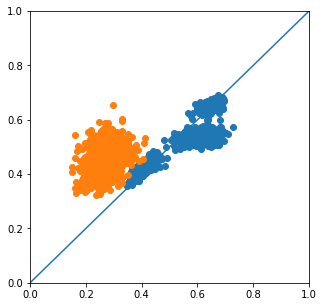

In [113]:
l = [i/1000 for i in range(1000)]

CQ = np.array(CQ)
hl = np.array(hl)
pitch = np.array(pitch)

plt.figure(figsize=(5, 5))
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.scatter(CQ[:,0],CQ[:,1],marker='o')
plt.scatter(hl[:,0],hl[:,1],marker='o')
plt.plot(l,l)
# plt.scatter(pitch[:,0],pitch[:,1])

print("CQ error: ",np.sqrt(np.mean((CQ[:,0]-CQ[:,1])**2)))
print("hl error: ",np.sqrt(np.mean((hl[:,0]-hl[:,1])**2)))
print("pitch error: ",np.sqrt(np.mean((pitch[:,0]-pitch[:,1])**2)))

# exp20
## 성대접촉률 오차

CQ error:  0.05420279037322348
hl error:  0.19256237578246502
pitch error:  6.669181762719323


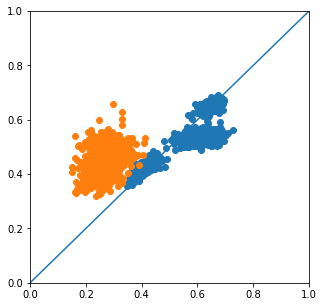

In [9]:
l = [i/1000 for i in range(1000)]

CQ = np.array(CQ)
hl = np.array(hl)
pitch = np.array(pitch)

plt.figure(figsize=(5, 5))
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.scatter(CQ[:,0],CQ[:,1],marker='o')
plt.scatter(hl[:,0],hl[:,1],marker='o')
plt.plot(l,l)
# plt.scatter(pitch[:,0],pitch[:,1])

print("CQ error: ",np.sqrt(np.mean((CQ[:,0]-CQ[:,1])**2)))
print("hl error: ",np.sqrt(np.mean((hl[:,0]-hl[:,1])**2)))
print("pitch error: ",np.sqrt(np.mean((pitch[:,0]-pitch[:,1])**2)))

# TEST saarbrucken Data
## Pathologic person data

In [7]:
window_step = 64
directory = './datasets/TestData/saarbrucken/'
filelist = os.listdir(directory)

DEGG_high_metrics_final = {'IDR':0, 'MR' : 0, 'FAR':0 ,'IDA':0,'ncycles':0,'nhits':0,'nmisses':0,'nfars':0}
DEGG_low_metrics_final = {'IDR':0, 'MR' : 0, 'FAR':0 ,'IDA':0,'ncycles':0,'nhits':0,'nmisses':0,'nfars':0}
EGG_high_metrics_final = {'IDR':0, 'MR' : 0, 'FAR':0 ,'IDA':0,'ncycles':0,'nhits':0,'nmisses':0,'nfars':0}
EGG_low_metrics_final = {'IDR':0, 'MR' : 0, 'FAR':0 ,'IDA':0,'ncycles':0,'nhits':0,'nmisses':0,'nfars':0}
# filelist = filelist[:]
for file in tqdm_notebook(filelist):
    [Speech,EGG_true],sr = librosa.load(directory + file,sr=16000,mono=False)
    Speech = butter_lowpass_filter(Speech,2500,16000)
    itvs = librosa.effects.split(Speech,frame_length = int(192*0.75), hop_length = int(192*0.25),top_db = 10)
    
    S = []
    E = []
    for st,ed in itvs:
        S += list(Speech[st:ed])
        E += list(EGG_true[st:ed])
    
    Speech = np.array(S)
    EGG_true = np.array(E)
    
    EGG_pred = inference(unet_cos,Speech,n_frame = 192,window_step = window_step)
    EGG_pred = np.squeeze(EGG_pred,axis=-1)
    EGG_pred = smooth(EGG_pred, 20)
    
    l = min(len(EGG_pred),len(EGG_true))
    EGG_true =EGG_true[:l]
    EGG_pred =EGG_pred[:l]
    
    DEGG_high_true,DEGG_low_true, EGG_high_true, EGG_low_true = get_points(EGG_true)
    DEGG_high_pred,DEGG_low_pred, EGG_high_pred, EGG_low_pred = get_points(EGG_pred)
    
    DEGG_high_metrics = corrected_naylor_metrics(DEGG_high_true, DEGG_high_pred) ##GOI
    DEGG_low_metrics = corrected_naylor_metrics(DEGG_low_true, DEGG_low_pred) ##GCI
    EGG_high_metrics = corrected_naylor_metrics(EGG_high_true, EGG_high_pred)
    EGG_low_metrics = corrected_naylor_metrics(EGG_low_true, EGG_low_pred)
    
    DEGG_high_metrics_final['ncycles'] +=DEGG_high_metrics['ncycles']
    DEGG_high_metrics_final['nhits'] +=DEGG_high_metrics['nhits']
    DEGG_high_metrics_final['nmisses'] +=DEGG_high_metrics['nmisses']
    DEGG_high_metrics_final['nfars'] +=DEGG_high_metrics['nfars']
    DEGG_high_metrics_final['IDA'] += DEGG_high_metrics["identification_accuracy"]/len(filelist)
    
    DEGG_low_metrics_final['ncycles'] +=DEGG_low_metrics['ncycles']
    DEGG_low_metrics_final['nhits'] +=DEGG_low_metrics['nhits']
    DEGG_low_metrics_final['nmisses'] +=DEGG_low_metrics['nmisses']
    DEGG_low_metrics_final['nfars'] +=DEGG_low_metrics['nfars']
    DEGG_low_metrics_final['IDA'] += DEGG_low_metrics["identification_accuracy"]/len(filelist)
    
    EGG_high_metrics_final['ncycles'] +=EGG_high_metrics['ncycles']
    EGG_high_metrics_final['nhits'] +=EGG_high_metrics['nhits']
    EGG_high_metrics_final['nmisses'] +=EGG_high_metrics['nmisses']
    EGG_high_metrics_final['nfars'] +=EGG_high_metrics['nfars']
    EGG_high_metrics_final['IDA'] += EGG_high_metrics["identification_accuracy"]/len(filelist)
    
    EGG_low_metrics_final['ncycles'] +=EGG_low_metrics['ncycles']
    EGG_low_metrics_final['nhits'] +=EGG_low_metrics['nhits']
    EGG_low_metrics_final['nmisses'] +=EGG_low_metrics['nmisses']
    EGG_low_metrics_final['nfars'] +=EGG_low_metrics['nfars']
    EGG_low_metrics_final['IDA'] += EGG_low_metrics["identification_accuracy"]/len(filelist)

for d in [DEGG_high_metrics_final,DEGG_low_metrics_final,EGG_high_metrics_final,EGG_low_metrics_final]:
    d['IDR'] = d['nhits']/d['ncycles']
    d['MR'] = d['nmisses']/d['ncycles']
    d['FAR'] = d['nfars']/d['ncycles']
    
print("=========DEGG_high(GOI) detection========")
print("IDR : %.2f MR : %.2f FAR : %.2f IDA : %.2f ms"
      %(DEGG_high_metrics_final['IDR']*100,DEGG_high_metrics_final['MR']*100,DEGG_high_metrics_final['FAR']*100,DEGG_high_metrics_final['IDA']*1000))

print("=========DEGG_low(GCI) detection========")
print("IDR : %.2f MR : %.2f FAR : %.2f IDA : %.2f ms"
      %(DEGG_low_metrics_final['IDR']*100,DEGG_low_metrics_final['MR']*100,DEGG_low_metrics_final['FAR']*100,DEGG_low_metrics_final['IDA']*1000))

print("=========EGG_high detection========")
print("IDR : %.2f MR : %.2f FAR : %.2f IDA : %.2f ms"
      %(EGG_high_metrics_final['IDR']*100,EGG_high_metrics_final['MR']*100,EGG_high_metrics_final['FAR']*100,EGG_high_metrics_final['IDA']*1000))

print("=========EGG_low detection========")
print("IDR : %.2f MR : %.2f FAR : %.2f IDA : %.2f ms"
      %(EGG_low_metrics_final['IDR']*100,EGG_low_metrics_final['MR']*100,EGG_low_metrics_final['FAR']*100,EGG_low_metrics_final['IDA']*1000))


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, a

KeyboardInterrupt: 

In [ ]:
window_step = 64
directory = './datasets/TestData/saarbrucken/'
filelist = os.listdir(directory)

DEGG_high_metrics_final = {'IDR':0, 'MR' : 0, 'FAR':0 ,'IDA':0,'ncycles':0,'nhits':0,'nmisses':0,'nfars':0}
DEGG_low_metrics_final = {'IDR':0, 'MR' : 0, 'FAR':0 ,'IDA':0,'ncycles':0,'nhits':0,'nmisses':0,'nfars':0}
EGG_high_metrics_final = {'IDR':0, 'MR' : 0, 'FAR':0 ,'IDA':0,'ncycles':0,'nhits':0,'nmisses':0,'nfars':0}
EGG_low_metrics_final = {'IDR':0, 'MR' : 0, 'FAR':0 ,'IDA':0,'ncycles':0,'nhits':0,'nmisses':0,'nfars':0}
# filelist = filelist[:]
for file in tqdm_notebook(filelist):
    [Speech,EGG_true],sr = librosa.load(directory + file,sr=16000,mono=False)
    Speech = butter_lowpass_filter(Speech,2500,16000)
    itvs = librosa.effects.split(Speech,frame_length = int(192*0.75), hop_length = int(192*0.25),top_db = 10)
    
    S = []
    E = []
    for st,ed in itvs:
        S += list(Speech[st:ed])
        E += list(EGG_true[st:ed])
    
    Speech = np.array(S)
    EGG_true = np.array(E)
    
    EGG_pred = inference(AAE_cos,Speech,n_frame = 192,window_step = window_step)
    EGG_pred = np.squeeze(EGG_pred,axis=-1)
    EGG_pred = smooth(EGG_pred, 20)
    
    l = min(len(EGG_pred),len(EGG_true))
    EGG_true =EGG_true[:l]
    EGG_pred =EGG_pred[:l]
    
    DEGG_high_true,DEGG_low_true, EGG_high_true, EGG_low_true = get_points(EGG_true)
    DEGG_high_pred,DEGG_low_pred, EGG_high_pred, EGG_low_pred = get_points(EGG_pred)
    
    DEGG_high_metrics = corrected_naylor_metrics(DEGG_high_true, DEGG_high_pred) ##GOI
    DEGG_low_metrics = corrected_naylor_metrics(DEGG_low_true, DEGG_low_pred) ##GCI
    EGG_high_metrics = corrected_naylor_metrics(EGG_high_true, EGG_high_pred)
    EGG_low_metrics = corrected_naylor_metrics(EGG_low_true, EGG_low_pred)
    
    DEGG_high_metrics_final['ncycles'] +=DEGG_high_metrics['ncycles']
    DEGG_high_metrics_final['nhits'] +=DEGG_high_metrics['nhits']
    DEGG_high_metrics_final['nmisses'] +=DEGG_high_metrics['nmisses']
    DEGG_high_metrics_final['nfars'] +=DEGG_high_metrics['nfars']
    DEGG_high_metrics_final['IDA'] += DEGG_high_metrics["identification_accuracy"]/len(filelist)
    
    DEGG_low_metrics_final['ncycles'] +=DEGG_low_metrics['ncycles']
    DEGG_low_metrics_final['nhits'] +=DEGG_low_metrics['nhits']
    DEGG_low_metrics_final['nmisses'] +=DEGG_low_metrics['nmisses']
    DEGG_low_metrics_final['nfars'] +=DEGG_low_metrics['nfars']
    DEGG_low_metrics_final['IDA'] += DEGG_low_metrics["identification_accuracy"]/len(filelist)
    
    EGG_high_metrics_final['ncycles'] +=EGG_high_metrics['ncycles']
    EGG_high_metrics_final['nhits'] +=EGG_high_metrics['nhits']
    EGG_high_metrics_final['nmisses'] +=EGG_high_metrics['nmisses']
    EGG_high_metrics_final['nfars'] +=EGG_high_metrics['nfars']
    EGG_high_metrics_final['IDA'] += EGG_high_metrics["identification_accuracy"]/len(filelist)
    
    EGG_low_metrics_final['ncycles'] +=EGG_low_metrics['ncycles']
    EGG_low_metrics_final['nhits'] +=EGG_low_metrics['nhits']
    EGG_low_metrics_final['nmisses'] +=EGG_low_metrics['nmisses']
    EGG_low_metrics_final['nfars'] +=EGG_low_metrics['nfars']
    EGG_low_metrics_final['IDA'] += EGG_low_metrics["identification_accuracy"]/len(filelist)

for d in [DEGG_high_metrics_final,DEGG_low_metrics_final,EGG_high_metrics_final,EGG_low_metrics_final]:
    d['IDR'] = d['nhits']/d['ncycles']
    d['MR'] = d['nmisses']/d['ncycles']
    d['FAR'] = d['nfars']/d['ncycles']
    
print("=========DEGG_high(GOI) detection========")
print("IDR : %.2f MR : %.2f FAR : %.2f IDA : %.2f ms"
      %(DEGG_high_metrics_final['IDR']*100,DEGG_high_metrics_final['MR']*100,DEGG_high_metrics_final['FAR']*100,DEGG_high_metrics_final['IDA']*1000))

print("=========DEGG_low(GCI) detection========")
print("IDR : %.2f MR : %.2f FAR : %.2f IDA : %.2f ms"
      %(DEGG_low_metrics_final['IDR']*100,DEGG_low_metrics_final['MR']*100,DEGG_low_metrics_final['FAR']*100,DEGG_low_metrics_final['IDA']*1000))

print("=========EGG_high detection========")
print("IDR : %.2f MR : %.2f FAR : %.2f IDA : %.2f ms"
      %(EGG_high_metrics_final['IDR']*100,EGG_high_metrics_final['MR']*100,EGG_high_metrics_final['FAR']*100,EGG_high_metrics_final['IDA']*1000))

print("=========EGG_low detection========")
print("IDR : %.2f MR : %.2f FAR : %.2f IDA : %.2f ms"
      %(EGG_low_metrics_final['IDR']*100,EGG_low_metrics_final['MR']*100,EGG_low_metrics_final['FAR']*100,EGG_low_metrics_final['IDA']*1000))


In [ ]:
window_step = 64
directory = './datasets/TestData/saarbrucken/'
filelist = os.listdir(directory)

DEGG_high_metrics_final = {'IDR':0, 'MR' : 0, 'FAR':0 ,'IDA':0,'ncycles':0,'nhits':0,'nmisses':0,'nfars':0}
DEGG_low_metrics_final = {'IDR':0, 'MR' : 0, 'FAR':0 ,'IDA':0,'ncycles':0,'nhits':0,'nmisses':0,'nfars':0}
EGG_high_metrics_final = {'IDR':0, 'MR' : 0, 'FAR':0 ,'IDA':0,'ncycles':0,'nhits':0,'nmisses':0,'nfars':0}
EGG_low_metrics_final = {'IDR':0, 'MR' : 0, 'FAR':0 ,'IDA':0,'ncycles':0,'nhits':0,'nmisses':0,'nfars':0}
# filelist = filelist[:]
for file in tqdm_notebook(filelist):
    [Speech,EGG_true],sr = librosa.load(directory + file,sr=16000,mono=False)
    Speech = butter_lowpass_filter(Speech,2500,16000)
    itvs = librosa.effects.split(Speech,frame_length = int(192*0.75), hop_length = int(192*0.25),top_db = 10)
    
    S = []
    E = []
    for st,ed in itvs:
        S += list(Speech[st:ed])
        E += list(EGG_true[st:ed])
    
    Speech = np.array(S)
    EGG_true = np.array(E)
    
    EGG_pred = inference(unet_mse,Speech,n_frame = 192,window_step = window_step)
    EGG_pred = np.squeeze(EGG_pred,axis=-1)
    EGG_pred = smooth(EGG_pred, 20)
    
    l = min(len(EGG_pred),len(EGG_true))
    EGG_true =EGG_true[:l]
    EGG_pred =EGG_pred[:l]
    
    DEGG_high_true,DEGG_low_true, EGG_high_true, EGG_low_true = get_points(EGG_true)
    DEGG_high_pred,DEGG_low_pred, EGG_high_pred, EGG_low_pred = get_points(EGG_pred)
    
    DEGG_high_metrics = corrected_naylor_metrics(DEGG_high_true, DEGG_high_pred) ##GOI
    DEGG_low_metrics = corrected_naylor_metrics(DEGG_low_true, DEGG_low_pred) ##GCI
    EGG_high_metrics = corrected_naylor_metrics(EGG_high_true, EGG_high_pred)
    EGG_low_metrics = corrected_naylor_metrics(EGG_low_true, EGG_low_pred)
    
    DEGG_high_metrics_final['ncycles'] +=DEGG_high_metrics['ncycles']
    DEGG_high_metrics_final['nhits'] +=DEGG_high_metrics['nhits']
    DEGG_high_metrics_final['nmisses'] +=DEGG_high_metrics['nmisses']
    DEGG_high_metrics_final['nfars'] +=DEGG_high_metrics['nfars']
    DEGG_high_metrics_final['IDA'] += DEGG_high_metrics["identification_accuracy"]/len(filelist)
    
    DEGG_low_metrics_final['ncycles'] +=DEGG_low_metrics['ncycles']
    DEGG_low_metrics_final['nhits'] +=DEGG_low_metrics['nhits']
    DEGG_low_metrics_final['nmisses'] +=DEGG_low_metrics['nmisses']
    DEGG_low_metrics_final['nfars'] +=DEGG_low_metrics['nfars']
    DEGG_low_metrics_final['IDA'] += DEGG_low_metrics["identification_accuracy"]/len(filelist)
    
    EGG_high_metrics_final['ncycles'] +=EGG_high_metrics['ncycles']
    EGG_high_metrics_final['nhits'] +=EGG_high_metrics['nhits']
    EGG_high_metrics_final['nmisses'] +=EGG_high_metrics['nmisses']
    EGG_high_metrics_final['nfars'] +=EGG_high_metrics['nfars']
    EGG_high_metrics_final['IDA'] += EGG_high_metrics["identification_accuracy"]/len(filelist)
    
    EGG_low_metrics_final['ncycles'] +=EGG_low_metrics['ncycles']
    EGG_low_metrics_final['nhits'] +=EGG_low_metrics['nhits']
    EGG_low_metrics_final['nmisses'] +=EGG_low_metrics['nmisses']
    EGG_low_metrics_final['nfars'] +=EGG_low_metrics['nfars']
    EGG_low_metrics_final['IDA'] += EGG_low_metrics["identification_accuracy"]/len(filelist)

for d in [DEGG_high_metrics_final,DEGG_low_metrics_final,EGG_high_metrics_final,EGG_low_metrics_final]:
    d['IDR'] = d['nhits']/d['ncycles']
    d['MR'] = d['nmisses']/d['ncycles']
    d['FAR'] = d['nfars']/d['ncycles']
    
print("=========DEGG_high(GOI) detection========")
print("IDR : %.2f MR : %.2f FAR : %.2f IDA : %.2f ms"
      %(DEGG_high_metrics_final['IDR']*100,DEGG_high_metrics_final['MR']*100,DEGG_high_metrics_final['FAR']*100,DEGG_high_metrics_final['IDA']*1000))

print("=========DEGG_low(GCI) detection========")
print("IDR : %.2f MR : %.2f FAR : %.2f IDA : %.2f ms"
      %(DEGG_low_metrics_final['IDR']*100,DEGG_low_metrics_final['MR']*100,DEGG_low_metrics_final['FAR']*100,DEGG_low_metrics_final['IDA']*1000))

print("=========EGG_high detection========")
print("IDR : %.2f MR : %.2f FAR : %.2f IDA : %.2f ms"
      %(EGG_high_metrics_final['IDR']*100,EGG_high_metrics_final['MR']*100,EGG_high_metrics_final['FAR']*100,EGG_high_metrics_final['IDA']*1000))

print("=========EGG_low detection========")
print("IDR : %.2f MR : %.2f FAR : %.2f IDA : %.2f ms"
      %(EGG_low_metrics_final['IDR']*100,EGG_low_metrics_final['MR']*100,EGG_low_metrics_final['FAR']*100,EGG_low_metrics_final['IDA']*1000))


# Real testing on singing voice

In [5]:
def get_points(EGG):
#     EGG = normalize(EGG)
    peak_range = (7,15)
    DEGG = np.gradient(EGG,edge_order = 2)
    DEGG = medfilt(DEGG, 3)
    DEGG_low,EGG_low = DEGG.copy(),EGG.copy()
    
    DEGG_low[DEGG_low>0] =0
    EGG_low[EGG_low>0] =0
    
    DEGG_low = find_peaks_cwt(-DEGG_low,np.arange(*peak_range))
    EGG_low = find_peaks_cwt(-EGG_low,np.arange(*peak_range))

#     EGG_low = []
    DEGG_high = []
    for i in range(len(DEGG_low)-1):
        DEGG_high.append(DEGG_low[i] + np.argmax(DEGG[DEGG_low[i]:DEGG_low[i+1]]))

    EGG_high = []
    for i in range(len(EGG_low)-1):
        EGG_high.append(EGG_low[i] + np.argmax(EGG[EGG_low[i]:EGG_low[i+1]]))
    
    DEGG_high, EGG_high = np.array(DEGG_high),np.array(EGG_high)
    
    return DEGG_high/16000,DEGG_low/16000,EGG_high/16000,EGG_low/16000

In [54]:
%%time
window_step = 64
directory = './applicable/'
file = 'park.wav'
Speech,sr = librosa.load(directory + file,sr=16000)
Speech = butter_lowpass_filter(Speech,2500,16000)


EGG_pred = inference(unet_cos,Speech,n_frame = 192,window_step = window_step)
EGG_pred = np.squeeze(EGG_pred,axis=-1)
EGG_pred = smooth(EGG_pred, 20)

CPU times: user 2min 10s, sys: 40.2 s, total: 2min 50s
Wall time: 2min 50s


In [13]:
ipd.Audio(Speech,rate=16000)

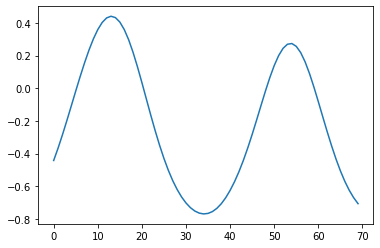

In [60]:
plt.plot(EGG_pred[538010:538080])

In [56]:
DEGG = np.gradient(EGG_pred,edge_order = 2)
DEGG = medfilt(DEGG, 3)

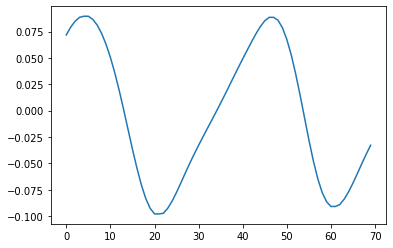

In [61]:
plt.plot(DEGG[538010:538080])

CPU times: user 11.9 s, sys: 56 ms, total: 11.9 s
Wall time: 8.15 s


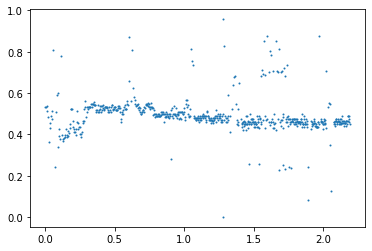

In [105]:
%%time

t1,t2 = 31.8,34

DEGG_high,DEGG_low, EGG_high, EGG_low = get_points(EGG_pred[int(t1*16000):int(t2*16000)])
T = []
CQ = []
xs = []
for i in range(len(DEGG_low) - 1):
    T.append(DEGG_low[i+1]-DEGG_low[i])

t = 0
for i in range(len(DEGG_low)-1):
    CQ.append((DEGG_high[i]-DEGG_low[i])/T[i])
    xs.append(t)
    t+=T[i]
# xs = np.array(range(len(CQ)))/16000
plt.plot(xs,CQ,'o',markersize=1)
ipd.Audio(Speech[int(t1*16000):int(t2*16000)],rate=16000)

In [106]:
ipd.Audio(Speech[int(31.8*16000):34*16000],rate=16000)

In [11]:
%%time
window_step = 64
directory = './datasets/applicable/'
file = 'naul.wav'
Speech,sr = librosa.load(directory + file,sr=16000)
Speech = butter_lowpass_filter(Speech,2500,16000)

EGG_pred = inference(res_plus,Speech,n_frame = 192,window_step = window_step)
EGG_pred = np.squeeze(EGG_pred,axis=-1)
EGG_pred = smooth(EGG_pred, 49)


FileNotFoundError: [Errno 2] No such file or directory: './datasets/applicable/naul.wav'

In [9]:
ipd.Audio(Speech,rate=16000)

CPU times: user 45.3 s, sys: 34 ms, total: 45.3 s
Wall time: 23.8 s


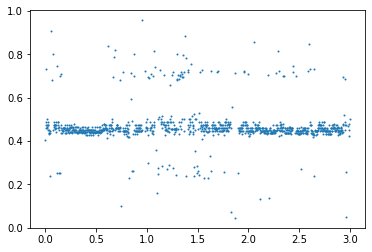

In [109]:
%%time

t1,t2 = 1,4

DEGG_high,DEGG_low, EGG_high, EGG_low = get_points(EGG_pred[int(t1*16000):int(t2*16000)])
T = []
CQ = []
xs = []
for i in range(len(DEGG_low) - 1):
    T.append(DEGG_low[i+1]-DEGG_low[i])

t = 0
for i in range(len(DEGG_low)-1):
    CQ.append((DEGG_high[i]-DEGG_low[i])/T[i])
    xs.append(t)
    t+=T[i]
# xs = np.array(range(len(CQ)))/16000
plt.plot(xs,CQ,'o',markersize=1)
ipd.Audio(Speech[int(t1*16000):int(t2*16000)],rate=16000)

CPU times: user 18.6 s, sys: 20.5 ms, total: 18.6 s
Wall time: 13.9 s


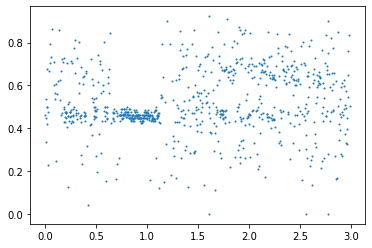

In [110]:
%%time

t1,t2 = 4,7

DEGG_high,DEGG_low, EGG_high, EGG_low = get_points(EGG_pred[int(t1*16000):int(t2*16000)])
T = []
CQ = []
xs = []
for i in range(len(DEGG_low) - 1):
    T.append(DEGG_low[i+1]-DEGG_low[i])

t = 0
for i in range(len(DEGG_low)-1):
    CQ.append((DEGG_high[i]-DEGG_low[i])/T[i])
    xs.append(t)
    t+=T[i]
# xs = np.array(range(len(CQ)))/16000
plt.plot(xs,CQ,'o',markersize=1)


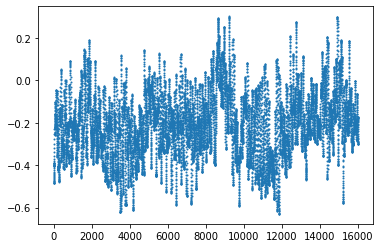

In [115]:
plt.plot(EGG_pred[int((t2-1)*16000):int(t2*16000)])

In [56]:
ipd.Audio(Speech[int(t1*16000):int(t2*16000)],rate=16000)

In [126]:
%%time
window_step = 64
directory = './'
file = 'general.wav'
Speech,sr = librosa.load(directory + file,sr=16000)
Speech = butter_lowpass_filter(Speech,2500,16000)

EGG_pred = inference(unet_cos,Speech,n_frame = 192,window_step = window_step)
EGG_pred = np.squeeze(EGG_pred,axis=-1)
EGG_pred = smooth(EGG_pred, 49)


CPU times: user 11.3 s, sys: 19.3 ms, total: 11.3 s
Wall time: 11.3 s


In [127]:
ipd.Audio(Speech,rate=16000)

CPU times: user 16.7 s, sys: 16.1 ms, total: 16.7 s
Wall time: 12.5 s


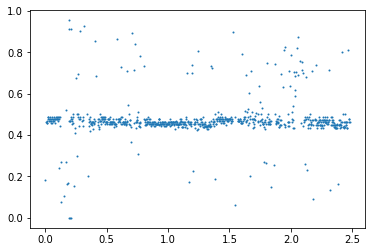

In [128]:
%%time

t1,t2 = 5,7.5

DEGG_high,DEGG_low, EGG_high, EGG_low = get_points(EGG_pred[int(t1*16000):int(t2*16000)])
T = []
CQ = []
xs = []
for i in range(len(DEGG_low) - 1):
    T.append(DEGG_low[i+1]-DEGG_low[i])

t = 0
for i in range(len(DEGG_low)-1):
    CQ.append((DEGG_high[i]-DEGG_low[i])/T[i])
    xs.append(t)
    t+=T[i]
# xs = np.array(range(len(CQ)))/16000
plt.plot(xs,CQ,'o',markersize=1)


In [129]:
ipd.Audio(Speech[int(t1*16000):int(t2*16000)],rate=16000)

In [84]:
ipd.Audio(Speech[int(t1*16000):int((t1+0.3)*16000)],rate=16000)

In [135]:
%%time
window_step = 64
directory = './'
file = 'general2.wav'
Speech,sr = librosa.load(directory + file,sr=16000)
Speech = butter_lowpass_filter(Speech,2500,16000)

EGG_pred = inference(unet_cos,Speech,n_frame = 192,window_step = window_step)
EGG_pred = np.squeeze(EGG_pred,axis=-1)
EGG_pred = smooth(EGG_pred, 49)


CPU times: user 11.8 s, sys: 15.4 ms, total: 11.8 s
Wall time: 11.8 s


In [136]:
ipd.Audio(Speech,rate=16000)

CPU times: user 35.8 s, sys: 32.9 ms, total: 35.8 s
Wall time: 31.1 s


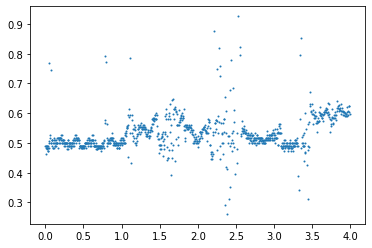

In [138]:
%%time

t1,t2 = 1,5

DEGG_high,DEGG_low, EGG_high, EGG_low = get_points(EGG_pred[int(t1*16000):int(t2*16000)])
T = []
CQ = []
xs = []
for i in range(len(DEGG_low) - 1):
    T.append(DEGG_low[i+1]-DEGG_low[i])

t = 0
for i in range(len(DEGG_low)-1):
    CQ.append((DEGG_high[i]-DEGG_low[i])/T[i])
    xs.append(t)
    t+=T[i]
# xs = np.array(range(len(CQ)))/16000
plt.plot(xs,CQ,'o',markersize=1)

In [139]:
ipd.Audio(Speech[int(t1*16000):int(t2*16000)],rate=16000)

In [140]:
%%time
window_step = 64
directory = './'
file = 'moonmoon.wav'
Speech,sr = librosa.load(directory + file,sr=16000)
Speech = butter_lowpass_filter(Speech,2500,16000)

EGG_pred = inference(unet_cos,Speech,n_frame = 192,window_step = window_step)
EGG_pred = np.squeeze(EGG_pred,axis=-1)
EGG_pred = smooth(EGG_pred, 49)


CPU times: user 6.2 s, sys: 31.5 ms, total: 6.23 s
Wall time: 6.24 s


In [141]:
ipd.Audio(Speech,rate=16000)

CPU times: user 45.5 s, sys: 48.4 ms, total: 45.5 s
Wall time: 37.3 s


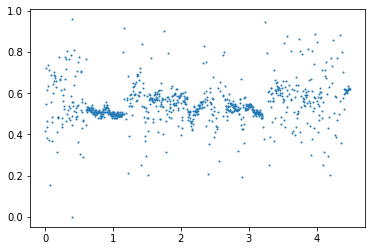

In [142]:
%%time

t1,t2 = 0.5,5

DEGG_high,DEGG_low, EGG_high, EGG_low = get_points(EGG_pred[int(t1*16000):int(t2*16000)])
T = []
CQ = []
xs = []
for i in range(len(DEGG_low) - 1):
    T.append(DEGG_low[i+1]-DEGG_low[i])

t = 0
for i in range(len(DEGG_low)-1):
    CQ.append((DEGG_high[i]-DEGG_low[i])/T[i])
    xs.append(t)
    t+=T[i]
# xs = np.array(range(len(CQ)))/16000
plt.plot(xs,CQ,'o',markersize=1)

In [143]:
ipd.Audio(Speech[int(t1*16000):int(t2*16000)],rate=16000)

In [116]:
%%time
window_step = 64
directory = './'
file = 'mine.wav'
Speech,sr = librosa.load(directory + file,sr=16000)
Speech = butter_lowpass_filter(Speech,2500,16000)

EGG_pred = inference(unet_cos,Speech,n_frame = 192,window_step = window_step)
EGG_pred = np.squeeze(EGG_pred,axis=-1)
EGG_pred = smooth(EGG_pred, 49)


CPU times: user 9.78 s, sys: 75.5 ms, total: 9.85 s
Wall time: 9.84 s


In [117]:
ipd.Audio(Speech,rate=16000)

CPU times: user 51 s, sys: 130 ms, total: 51.1 s
Wall time: 46.3 s


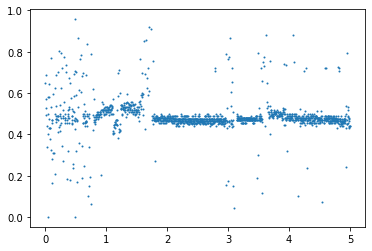

In [118]:
%%time

t1,t2 = 1,6

DEGG_high,DEGG_low, EGG_high, EGG_low = get_points(EGG_pred[int(t1*16000):int(t2*16000)])
T = []
CQ = []
xs = []
for i in range(len(DEGG_low) - 1):
    T.append(DEGG_low[i+1]-DEGG_low[i])

t = 0
for i in range(len(DEGG_low)-1):
    CQ.append((DEGG_high[i]-DEGG_low[i])/T[i])
    xs.append(t)
    t+=T[i]
# xs = np.array(range(len(CQ)))/16000
plt.plot(xs,CQ,'o',markersize=1)

In [119]:
ipd.Audio(Speech[int(t1*16000):int(t2*16000)],rate=16000)

In [58]:
%%time
window_step = 64
directory = './datasets/TestData/CMU/'
file = 'bdl_arctic_b0500.wav'
[Speech,EGG_true],sr = librosa.load(directory + file,sr=16000,mono=False)
Speech = butter_lowpass_filter(Speech,2500,16000)

EGG_pred = inference(res_unet_2,Speech,n_frame = 192,window_step = window_step)
EGG_pred = np.squeeze(EGG_pred,axis=-1)
# EGG_pred = smooth(EGG_pred, 15)


CPU times: user 6.82 s, sys: 1.23 s, total: 8.05 s
Wall time: 8.05 s


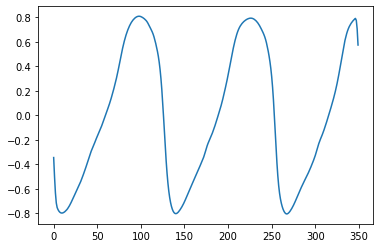

In [54]:
plt.plot(smooth(EGG_pred[4050:4400],10))

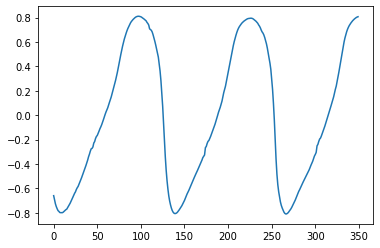

Exception ignored in: <function Wave_write.__del__ at 0x7fa59ca0e0d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/wave.py", line 327, in __del__
    self.close()
  File "/opt/conda/lib/python3.7/wave.py", line 445, in close
    self._ensure_header_written(0)
  File "/opt/conda/lib/python3.7/wave.py", line 465, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


In [48]:
plt.plot(EGG_pred[4050:4400])

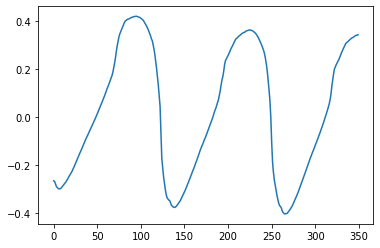

In [52]:
plt.plot(EGG_true[4050:4400])

In [125]:
ipd.Audio(Speech,rate=16000)

CPU times: user 8.47 s, sys: 25.2 ms, total: 8.49 s
Wall time: 5.58 s


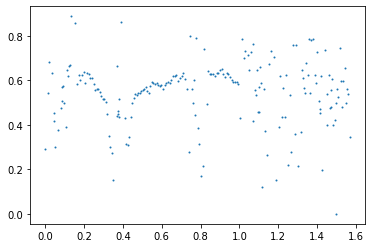

In [57]:
%%time

DEGG_high,DEGG_low, EGG_high, EGG_low = get_points(smooth(EGG_pred,49))
T = []
CQ = []
xs = []
for i in range(len(DEGG_low) - 1):
    T.append(DEGG_low[i+1]-DEGG_low[i])

t = 0
for i in range(len(DEGG_low)-1):
    CQ.append((DEGG_high[i]-DEGG_low[i])/T[i])
    xs.append(t)
    t+=T[i]
# xs = np.array(range(len(CQ)))/16000
plt.plot(xs,CQ,'o',markersize=1)

CPU times: user 8.12 s, sys: 15.3 ms, total: 8.13 s
Wall time: 5.3 s


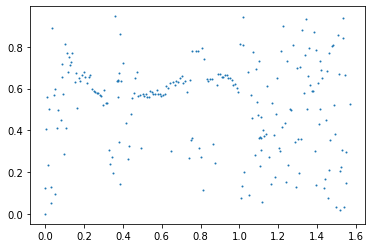

In [60]:
%%time

DEGG_high,DEGG_low, EGG_high, EGG_low = get_points(smooth(EGG_pred,3))
T = []
CQ = []
xs = []
for i in range(len(DEGG_low) - 1):
    T.append(DEGG_low[i+1]-DEGG_low[i])

t = 0
for i in range(len(DEGG_low)-1):
    CQ.append((DEGG_high[i]-DEGG_low[i])/T[i])
    xs.append(t)
    t+=T[i]
# xs = np.array(range(len(CQ)))/16000
plt.plot(xs,CQ,'o',markersize=1)

CPU times: user 8.89 s, sys: 6.31 ms, total: 8.9 s
Wall time: 5.87 s


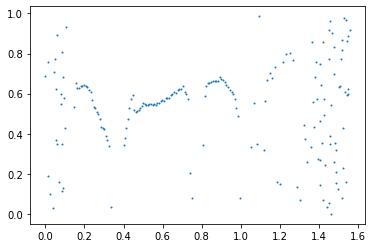

In [124]:
%%time

DEGG_high,DEGG_low, EGG_high, EGG_low = get_points(EGG_true)
T = []
CQ = []
xs = []
for i in range(len(DEGG_low) - 1):
    T.append(DEGG_low[i+1]-DEGG_low[i])

t = 0
for i in range(len(DEGG_low)-1):
    CQ.append((DEGG_high[i]-DEGG_low[i])/T[i])
    xs.append(t)
    t+=T[i]
# xs = np.array(range(len(CQ)))/16000
plt.plot(xs,CQ,'o',markersize=1)